In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_dataset(filename):
    # read data
    file = open(filename, "r")
    lines = file.readlines()
    file.close()

    # filter into a dataframe
    dataset = pd.DataFrame(0.0, index=np.arange(len(lines)), columns=['x1', 'x2', 'output'])
    for i in range(0, dataset.shape[0]):
        arr = lines[i].replace('\n', '').strip().split(" ")

        if len(arr) >= 4:
            for k in range(2):
                arr.pop(1)

        for j in range(0, len(arr)):
            if arr[j] != '' and arr[j] != ' ':
                dataset.iloc[i][j] = float(arr[j])

    return dataset

In [3]:
dataset_training_1 = read_dataset("dataset1_training.txt")
dataset_training_2 = read_dataset("dataset2_training.txt")
dataset_testing_1 = read_dataset("dataset1_testing.txt")
dataset_testing_2 = read_dataset("dataset2_testing.txt")

display(dataset_training_1.head(3))
display(dataset_training_2.head(3))
display(dataset_testing_1.head(3))
display(dataset_testing_2.head(3))

,x1,x2,output
0,1.53,3.13,0.0
1,0.58,2.83,0.0
2,0.28,2.69,0.0


,x1,x2,output
0,0.130359,0.026001,1.0
1,-0.274629,0.985175,0.0
2,-0.004553,0.074094,1.0


,x1,x2,output
0,2.16,3.91,0.0
1,-0.22,1.73,0.0
2,2.00,3.92,0.0


,x1,x2,output
0,-0.031390,1.015639,0.0
1,0.309430,-0.208743,1.0
2,0.439711,0.859860,0.0


### Problem 1: Build Neural Network

In [4]:
from math import exp
from random import random

In [5]:
def initialize_helper(cols, rows):
    d = [(random() for i in range(cols+2)) for j in range(rows)]
    ind = ["n"+str(i+1) for i in range(rows)]
    col = ["w"+str(i+1) for i in range(cols)]
    col.append("bias")
    col.append("output")
    col.append("delta")
    
    return d, ind, col

# create a random network
def initialize_network(n_inputs, n_hidden, n_outputs):
        
    d_hidden, ind_hidden, col_hidden = initialize_helper(n_inputs, n_hidden)
    
    d_output, ind_output, col_output = initialize_helper(n_hidden, n_outputs)
    
    hidden_layer = pd.DataFrame(data=d_hidden, index=ind_hidden, columns=col_hidden[:-1])
    hidden_layer['output'] = 0.0
    hidden_layer['delta'] = 0.0
    
    output_layer = pd.DataFrame(data=d_output, index=ind_output, columns=col_output[:-1])
    output_layer['output'] = 0.0
    output_layer['delta'] = 0.0
    
    return hidden_layer, output_layer

In [6]:
# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(hidden, output, row):
    inputs = row
    
    new_inputs = []
    for n in hidden.index:
        neuron = hidden.loc[n]
        activation = activate(neuron[:-2], inputs)
        neuron[['output']] = transfer(activation)
        new_inputs.append(neuron[['output']])
    inputs = new_inputs
    
    new_inputs = []
    for o in output.index:
        neuron = output.loc[o]
        activation = activate(neuron[:-2], inputs)
        neuron[['output']] = transfer(activation)
        new_inputs.append(neuron[['output']])
    inputs = new_inputs

    return inputs

In [7]:
def transfer_derivative(output):
    return output * (1.0 - output)

def backward_propagate_error(hidden, output_layer, expected):
    errors = []
    for j in range(len(output_layer.index)):
        neuron = output_layer.iloc[j]
        errors.append(neuron['output'] - expected[j])
        
    for k in range(len(output_layer.index)):
        neuron = output_layer.iloc[k]
        neuron['delta'] = errors[k] * transfer_derivative(neuron['output'])
    
    errors = []
    for i in range(len(hidden.index)):
        error = 0.0
        for m in output_layer.index:
            neuron = output_layer.loc[m]
            error += (neuron.iloc[i] * neuron['delta'])
        errors.append(error)
        
    for k in range(len(hidden.index)):
        neuron = hidden.iloc[k]
        neuron['delta'] = errors[k] * transfer_derivative(neuron['output'])

In [8]:
# Make a prediction with a network
def predict(outputs):
    if(outputs[0]['output']>outputs[1]['output']):
        return 0
    else:
        return 1

In [9]:
# Update network weights with error
def update_weights(hidden, output_layer, row, l_rate):
    for i in hidden.index:
        inputs = row[:-1]
        neuron = hidden.loc[i]
        for k in range(len(inputs)):
            neuron[k] -= l_rate * neuron['delta'] * inputs[k]
        neuron['bias'] -= l_rate * neuron['delta']
        
    for j in output_layer.index:
        inputs = [hidden.loc[n]['output'] for n in hidden.index]
        neuron = output_layer.loc[j]
        for k in range(len(inputs)):
            neuron[k] -= l_rate * neuron['delta'] * inputs[k]
        neuron['bias'] -= l_rate * neuron['delta']
            
            
# Train a network for a fixed number of epochs
def train_network(hidden, output_layer, train_data, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        correct = 0
        sum_error = 0
        for m in train_data.index:
            row = train_data.loc[m]
            outputs = forward_propagate(hidden, output_layer, row)
            if(predict(outputs) == int(row['output'])):
                correct += 1
            expected = [0 for i in range(n_outputs)]
            expected[int(row[-1])] = 1
            sum_error += sum([(expected[i]-outputs[i]['output'])**2 for i in range(len(expected))])
            backward_propagate_error(hidden, output_layer, expected)
            update_weights(hidden, output_layer, row, l_rate)
        print('\n>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        print("Accuracy of Neural Network: {0:.2f}%".format(round((correct/train_data.shape[0])*100), 2))

In [10]:
def visualize_neural_network(X_train, y_train, X_test, y_test, y_pred):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
    a = [ax for ax in axes.flat]
    dataset = [X_train, y_train, X_test, y_test, X_test, y_pred]
    types = ["Training Data", "Testing Data (Expected)", "Testing Data (Predicted)"]
    
    for i in range(len(a)):
        # plot points
        a[i].scatter(dataset[i*2][['x1']], dataset[i*2][['x2']], c=dataset[i*2+1], s=10, cmap='RdBu')
        a[i].set_title(types[i])

#### Dataset 1

In [11]:
train_1 = dataset_training_1.copy()
test_1 = dataset_testing_1.copy()

In [12]:
n_inputs = train_1.iloc[0].shape[0] - 1
n_outputs = 2
h, o = initialize_network(n_inputs, 4, n_outputs)
display(h)
display(o)
train_network(h, o, train_1, 0.8, 5, n_outputs)
display(h)
display(o)

,w1,w2,bias,output,delta
n1,0.743283,0.137000,0.465347,0.0,0.0
n2,0.223949,0.637542,0.748000,0.0,0.0
n3,0.845258,0.669254,0.426081,0.0,0.0
n4,0.573809,0.086253,0.155064,0.0,0.0


,w1,w2,w3,w4,bias,output,delta
n1,0.989386,0.550201,0.873781,0.690180,0.192577,0.0,0.0
n2,0.614455,0.031339,0.116448,0.009241,0.392671,0.0,0.0



>epoch=0, lrate=0.800, error=58.259
Accuracy of Neural Network: 94.00%

>epoch=1, lrate=0.800, error=57.419
Accuracy of Neural Network: 93.00%

>epoch=2, lrate=0.800, error=35.191
Accuracy of Neural Network: 96.00%

>epoch=3, lrate=0.800, error=27.854
Accuracy of Neural Network: 97.00%

>epoch=4, lrate=0.800, error=25.593
Accuracy of Neural Network: 97.00%


,w1,w2,bias,output,delta
n1,1.553780,-1.439147,-0.024336,0.976321,-0.000638
n2,-1.937429,1.599927,0.730680,0.018538,0.000645
n3,0.454774,0.817880,0.382566,0.842748,0.000193
n4,-0.317551,0.365945,0.022226,0.325498,0.000583


,w1,w2,w3,w4,bias,output,delta
n1,-2.244262,3.253267,0.142121,0.240616,-0.543895,0.078417,0.005667
n2,2.652320,-3.021301,-0.107482,-0.226200,0.110310,0.921804,-0.005636


In [13]:
y_pred_1 = []
correct = 0
sum_error = 0
for m in test_1.index:
    row = test_1.loc[m]
    outputs = forward_propagate(h, o, row)
    prediction = predict(outputs)
    y_pred_1.append(prediction)
    if(prediction == int(row['output'])):
        correct += 1
    expected = [0 for i in range(n_outputs)]
    expected[int(row[-1])] = 1
    sum_error += sum([(expected[i]-outputs[i]['output'])**2 for i in range(len(expected))])
print("Accuracy of Neural Network on Testing Set 1: {0:.2f}%".format(round((correct/test_1.shape[0])*100), 2))

Accuracy of Neural Network on Testing Set 1: 97.00%


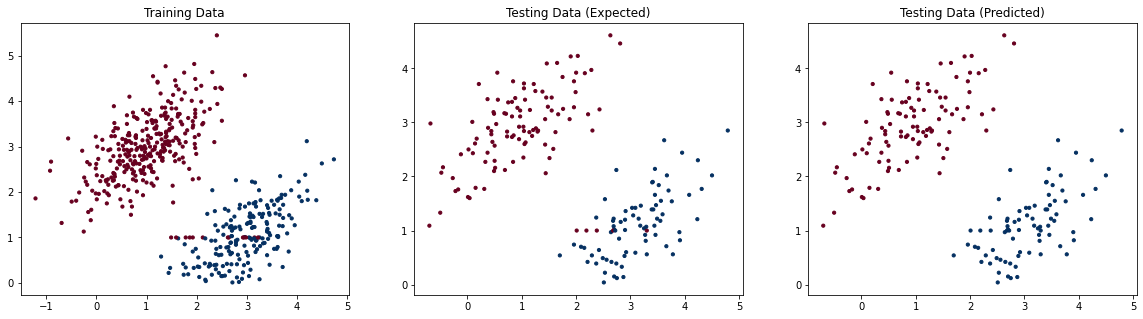

In [14]:
visualize_neural_network(train_1[['x1','x2']], train_1['output'], test_1[['x1', 'x2']], test_1['output'], y_pred_1)

#### Dataset 2

In [15]:
train_2 = dataset_training_2.copy()
test_2 = dataset_testing_2.copy()

In [16]:
n_inputs = train_2.iloc[0].shape[0] - 1
n_outputs = 2
h, o = initialize_network(n_inputs, 4, n_outputs)
display(h)
display(o)
train_network(h, o, train_2, 0.8, 5, n_outputs)
display(h)
display(o)

,w1,w2,bias,output,delta
n1,0.746114,0.482229,0.473410,0.0,0.0
n2,0.386934,0.405697,0.256433,0.0,0.0
n3,0.838265,0.864186,0.436121,0.0,0.0
n4,0.085129,0.102243,0.556433,0.0,0.0


,w1,w2,w3,w4,bias,output,delta
n1,0.893392,0.430070,0.177128,0.486124,0.925474,0.0,0.0
n2,0.505669,0.618756,0.626186,0.576046,0.341201,0.0,0.0



>epoch=0, lrate=0.800, error=255.462
Accuracy of Neural Network: 80.00%

>epoch=1, lrate=0.800, error=169.411
Accuracy of Neural Network: 88.00%

>epoch=2, lrate=0.800, error=167.750
Accuracy of Neural Network: 88.00%

>epoch=3, lrate=0.800, error=166.256
Accuracy of Neural Network: 88.00%

>epoch=4, lrate=0.800, error=164.985
Accuracy of Neural Network: 88.00%


,w1,w2,bias,output,delta
n1,-1.016707,3.974532,-2.409258,0.192244,0.123502
n2,0.930840,-4.085831,-0.419175,0.198042,-0.104861
n3,0.962787,-4.449364,-0.528852,0.170034,-0.103894
n4,0.320740,-1.386840,-0.571600,0.287329,-0.040642


,w1,w2,w3,w4,bias,output,delta
n1,2.777811,-2.132758,-2.588769,-0.615993,0.914314,0.633799,0.147103
n2,-2.578611,2.397789,2.451403,0.799488,-1.054410,0.361524,-0.147376


In [17]:
y_pred_2 = []
correct = 0
sum_error = 0
for m in test_2.index:
    row = test_2.loc[m]
    outputs = forward_propagate(h, o, row)
    prediction = predict(outputs)
    y_pred_2.append(prediction)
    if(prediction == int(row['output'])):
        correct += 1
    expected = [0 for i in range(n_outputs)]
    expected[int(row[-1])] = 1
    sum_error += sum([(expected[i]-outputs[i]['output'])**2 for i in range(len(expected))])
print("Accuracy of Neural Network on Testing Set 2: {0:.2f}%".format(round((correct/test_2.shape[0])*100), 2))

Accuracy of Neural Network on Testing Set 2: 89.00%


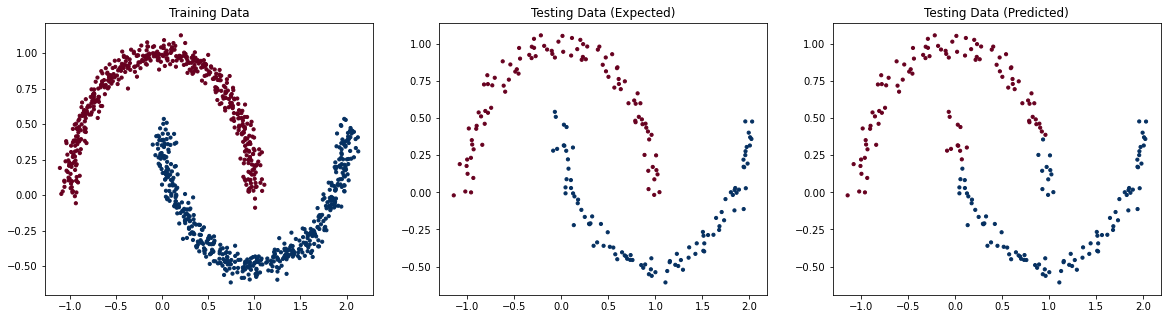

In [18]:
visualize_neural_network(train_2[['x1','x2']], train_2['output'], test_2[['x1', 'x2']], test_2['output'], y_pred_2)

### Problem 2: Use SVM and Visualize Result

In [19]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [20]:
# split into training and testing (X, y) variables
X_train_1 = dataset_training_1[['x1', 'x2']]
X_train_2 = dataset_training_2[['x1', 'x2']]

y_train_1 = dataset_training_1['output']
y_train_2 = dataset_training_2['output']

X_test_1 = dataset_testing_1[['x1', 'x2']]
X_test_2 = dataset_testing_2[['x1', 'x2']]

y_test_1 = dataset_testing_1['output']
y_test_2 = dataset_testing_2['output']

In [21]:
# for dataset 1 that is linearly separable
clf_linear = svm.SVC(kernel="linear")
clf_linear.fit(X_train_1, y_train_1)
y_pred_1 = clf_linear.predict(X_test_1)

In [22]:
# for dataset 2 that is non-linearly separable
clf_non_linear = svm.SVC(kernel="rbf")
clf_non_linear.fit(X_train_2, y_train_2)
y_pred_2 = clf_non_linear.predict(X_test_2)

In [23]:
# visualization reference: https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92
def visualize_training_testing(X_train, y_train, X_test, y_test, y_pred, model):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
    a = [ax for ax in axes.flat]
    dataset = [X_train, y_train, X_test, y_test, X_test, y_pred]
    types = ["Training Data", "Testing Data (Expected)", "Testing Data (Predicted)"]
    
    for i in range(len(a)):
        # plot points
        a[i].scatter(dataset[i*2][['x1']], dataset[i*2][['x2']], c=dataset[i*2+1], s=10, cmap='RdBu')
        a[i].set_title(types[i])
        
        # calculate boundary
        xlim = a[i].get_xlim()
        ylim = a[i].get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = model.decision_function(xy).reshape(XX.shape)

        # visualize boundary
        a[i].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

Accuracy with Linear SVM on Training & Testing Set 1: 97.22%


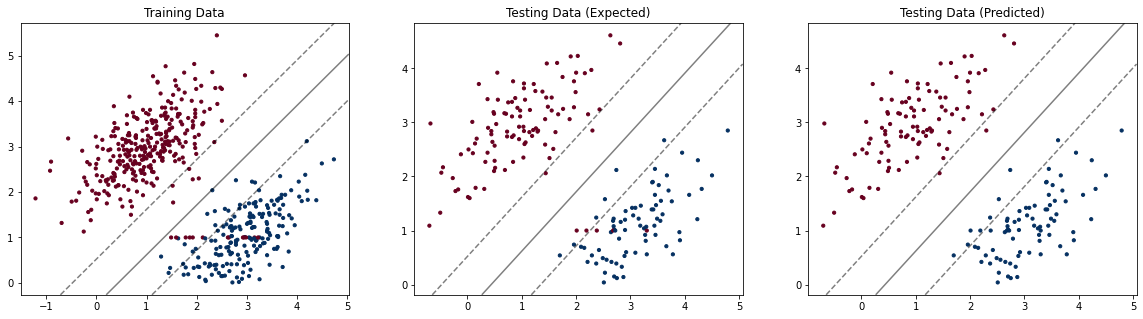

In [24]:
print("Accuracy with Linear SVM on Training & Testing Set 1: {0:.2f}%".format(accuracy_score(y_test_1, y_pred_1)*100, 2))
visualize_training_testing(X_train_1, y_train_1, X_test_1, y_test_1, y_pred_1, clf_linear)

Accuracy with RBF SVM on Training & Testing Set 2: 100.00%


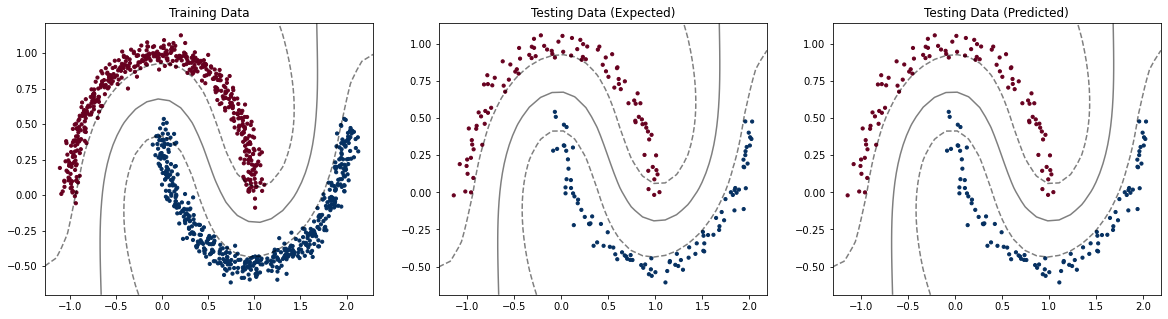

In [25]:
print("Accuracy with RBF SVM on Training & Testing Set 2: {0:.2f}%".format(accuracy_score(y_test_2, y_pred_2)*100, 2))
visualize_training_testing(X_train_2, y_train_2, X_test_2, y_test_2, y_pred_2, clf_non_linear)